In [33]:
# from sklearn.datasets import make_multilabel_classification
from torch.utils.data import Dataset
import json
import numpy as np
import torch
import time
from tqdm import tqdm

from preprocessing import for_train

In [34]:
X, y = for_train("year_venue")

delet some useless data: 100%|██████████| 25793/25793 [00:01<00:00, 13610.42it/s]


Number of instance with label :  7460
Number of instance without label(remain) :  1894


authors: 100%|██████████| 25793/25793 [00:06<00:00, 4171.57it/s]


In [35]:
print(X.shape)

N_FEATURES = X.shape[1]

torch.Size([9354, 486])


In [36]:
from sklearn.model_selection import train_test_split

# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=20)

X_train = X
X_test = X
y_train = y
y_test = y

print("Train:")
print("     X_train : ", X_train.shape)
print("     y_train : ", y_train.shape)
print("Test_Kaggle:")
print("     X_test  : ", X_test.shape)
print("     y_test  : ", y_test.shape)


Train:
     X_train :  torch.Size([9354, 486])
     y_train :  torch.Size([9354, 100])
Test_Kaggle:
     X_test  :  torch.Size([9354, 486])
     y_test  :  torch.Size([9354, 100])


In [37]:
from NN_Models import *

In [38]:
print(f"[INFO]: Number of training samples: {X_train.shape[0]}")
print(f"[INFO]: Number of training features: {X_train.shape[1]}")

# train data loader
train_dataset, train_dataloader = BinaryDataLoader(X_train, y_train, shuffle=True, batch_size=100)

# initialize the model
model = NeuralNetworkYearVenue()

[INFO]: Number of training samples: 9354
[INFO]: Number of training features: 486


In [39]:
import torch.optim as optim

# learning parameters
optimizer = optim.Adam(params=model.parameters(), lr=0.001) # 学习率衰减 / 学习率震荡
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
epochs = 100

# load the model on to the computation device
model.to(device)

NeuralNetworkYearVenue(
  (fc1): Linear(in_features=486, out_features=256, bias=True)
  (out): Linear(in_features=256, out_features=100, bias=True)
)

In [40]:
import torch

# start the training
start = time.time()
train_loss = []
for epoch in range(epochs):
    print(f"Epoch {epoch+1} of {epochs}")
    train_epoch_loss = train(
        model, train_dataloader, optimizer, loss_fn, train_dataset, device
    )
    train_loss.append(train_epoch_loss)
    print(f"Train Loss: {train_epoch_loss:.4f}")
torch.save(model.state_dict(), 'status/model_year_venue.pth')

print("="*25)
print(time.time()-start, 's')

Epoch 1 of 100


  0%|          | 0/93 [00:00<?, ?it/s]/Users/messifr/Desktop/Messi/MasterY1S2/sml/COMP90051_Project2/code/multi_layer_models/NN_Models.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  features = torch.tensor(features, dtype=torch.float32)
/Users/messifr/Desktop/Messi/MasterY1S2/sml/COMP90051_Project2/code/multi_layer_models/NN_Models.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label_dict[key] = torch.tensor(labels[i], dtype=torch.float32)
94it [00:19,  4.81it/s]                        


Train Loss: 0.2976
Epoch 2 of 100


94it [00:15,  6.11it/s]                        


Train Loss: 0.0552
Epoch 3 of 100


94it [00:11,  7.96it/s]                        


Train Loss: 0.0543
Epoch 4 of 100


94it [00:12,  7.83it/s]                        


Train Loss: 0.0540
Epoch 5 of 100


94it [00:11,  8.12it/s]                        


Train Loss: 0.0537
Epoch 6 of 100


94it [00:16,  5.65it/s]                        


Train Loss: 0.0536
Epoch 7 of 100


94it [00:12,  7.26it/s]                        


Train Loss: 0.0534
Epoch 8 of 100


94it [00:12,  7.43it/s]                        


Train Loss: 0.0532
Epoch 9 of 100


94it [00:11,  8.03it/s]                        


Train Loss: 0.0530
Epoch 10 of 100


94it [00:11,  8.45it/s]                        


Train Loss: 0.0527
Epoch 11 of 100


94it [00:10,  8.89it/s]                        


Train Loss: 0.0524
Epoch 12 of 100


94it [00:10,  8.73it/s]                        


Train Loss: 0.0521
Epoch 13 of 100


94it [00:10,  8.61it/s]                        


Train Loss: 0.0517
Epoch 14 of 100


94it [00:10,  8.71it/s]                        


Train Loss: 0.0513
Epoch 15 of 100


94it [00:11,  8.04it/s]                        


Train Loss: 0.0509
Epoch 16 of 100


94it [00:12,  7.62it/s]                        


Train Loss: 0.0504
Epoch 17 of 100


94it [00:13,  7.23it/s]                        


Train Loss: 0.0501
Epoch 18 of 100


94it [00:11,  7.97it/s]                        


Train Loss: 0.0498
Epoch 19 of 100


94it [00:13,  7.16it/s]                        


Train Loss: 0.0494
Epoch 20 of 100


94it [00:11,  8.23it/s]                        


Train Loss: 0.0490
Epoch 21 of 100


94it [00:11,  7.96it/s]                        


Train Loss: 0.0487
Epoch 22 of 100


94it [00:11,  8.38it/s]                        


Train Loss: 0.0483
Epoch 23 of 100


94it [00:11,  7.96it/s]                        


Train Loss: 0.0480
Epoch 24 of 100


94it [00:15,  6.20it/s]                        


Train Loss: 0.0478
Epoch 25 of 100


94it [00:12,  7.79it/s]                        


Train Loss: 0.0474
Epoch 26 of 100


94it [00:11,  8.08it/s]                        


Train Loss: 0.0472
Epoch 27 of 100


94it [00:15,  6.17it/s]                        


Train Loss: 0.0469
Epoch 28 of 100


94it [00:13,  7.18it/s]                        


Train Loss: 0.0467
Epoch 29 of 100


94it [00:13,  7.22it/s]                        


Train Loss: 0.0464
Epoch 30 of 100


94it [00:19,  4.90it/s]                        


Train Loss: 0.0461
Epoch 31 of 100


94it [00:12,  7.54it/s]                        


Train Loss: 0.0459
Epoch 32 of 100


94it [00:11,  8.44it/s]                        


Train Loss: 0.0457
Epoch 33 of 100


94it [00:10,  8.85it/s]                        


Train Loss: 0.0455
Epoch 34 of 100


94it [00:10,  8.87it/s]                        


Train Loss: 0.0454
Epoch 35 of 100


94it [00:10,  8.70it/s]                        


Train Loss: 0.0452
Epoch 36 of 100


94it [00:11,  8.20it/s]                        


Train Loss: 0.0450
Epoch 37 of 100


94it [00:10,  9.10it/s]                        


Train Loss: 0.0449
Epoch 38 of 100


94it [00:11,  7.86it/s]                        


Train Loss: 0.0447
Epoch 39 of 100


94it [00:10,  8.68it/s]                        


Train Loss: 0.0446
Epoch 40 of 100


94it [00:10,  8.96it/s]                        


Train Loss: 0.0445
Epoch 41 of 100


94it [00:10,  8.76it/s]                        


Train Loss: 0.0443
Epoch 42 of 100


94it [00:12,  7.32it/s]                        


Train Loss: 0.0441
Epoch 43 of 100


94it [00:11,  8.37it/s]                        


Train Loss: 0.0441
Epoch 44 of 100


94it [00:10,  8.81it/s]                        


Train Loss: 0.0440
Epoch 45 of 100


94it [00:10,  8.78it/s]                        


Train Loss: 0.0439
Epoch 46 of 100


94it [00:10,  8.88it/s]                        


Train Loss: 0.0438
Epoch 47 of 100


94it [00:15,  6.26it/s]                        


Train Loss: 0.0437
Epoch 48 of 100


94it [00:12,  7.64it/s]                        


Train Loss: 0.0436
Epoch 49 of 100


94it [00:11,  7.99it/s]                        


Train Loss: 0.0435
Epoch 50 of 100


94it [00:11,  8.12it/s]                        


Train Loss: 0.0435
Epoch 51 of 100


94it [00:13,  6.82it/s]                        


Train Loss: 0.0433
Epoch 52 of 100


94it [00:13,  7.17it/s]                        


Train Loss: 0.0433
Epoch 53 of 100


94it [00:12,  7.73it/s]                        


Train Loss: 0.0432
Epoch 54 of 100


94it [00:10,  8.69it/s]                        


Train Loss: 0.0431
Epoch 55 of 100


94it [00:11,  8.25it/s]                        


Train Loss: 0.0430
Epoch 56 of 100


94it [00:15,  6.02it/s]                        


Train Loss: 0.0429
Epoch 57 of 100


94it [00:13,  6.89it/s]                        


Train Loss: 0.0429
Epoch 58 of 100


94it [00:12,  7.56it/s]                        


Train Loss: 0.0428
Epoch 59 of 100


94it [00:11,  8.14it/s]                        


Train Loss: 0.0428
Epoch 60 of 100


94it [00:13,  6.98it/s]                        


Train Loss: 0.0427
Epoch 61 of 100


94it [00:12,  7.25it/s]                        


Train Loss: 0.0427
Epoch 62 of 100


94it [00:11,  8.06it/s]                        


Train Loss: 0.0426
Epoch 63 of 100


94it [00:11,  8.09it/s]                        


Train Loss: 0.0425
Epoch 64 of 100


94it [00:11,  8.41it/s]                        


Train Loss: 0.0424
Epoch 65 of 100


94it [00:11,  8.31it/s]                        


Train Loss: 0.0424
Epoch 66 of 100


94it [00:12,  7.30it/s]                        


Train Loss: 0.0424
Epoch 67 of 100


94it [00:12,  7.68it/s]                        


Train Loss: 0.0423
Epoch 68 of 100


94it [00:11,  8.43it/s]                        


Train Loss: 0.0423
Epoch 69 of 100


94it [00:11,  7.83it/s]                        


Train Loss: 0.0422
Epoch 70 of 100


94it [00:11,  8.16it/s]                        


Train Loss: 0.0421
Epoch 71 of 100


94it [00:12,  7.53it/s]                        


Train Loss: 0.0420
Epoch 72 of 100


94it [00:11,  8.15it/s]                        


Train Loss: 0.0420
Epoch 73 of 100


94it [00:11,  8.12it/s]                        


Train Loss: 0.0419
Epoch 74 of 100


94it [00:12,  7.68it/s]                        


Train Loss: 0.0419
Epoch 75 of 100


94it [00:11,  8.23it/s]                        


Train Loss: 0.0419
Epoch 76 of 100


94it [00:12,  7.68it/s]                        


Train Loss: 0.0418
Epoch 77 of 100


94it [00:11,  8.04it/s]                        


Train Loss: 0.0417
Epoch 78 of 100


94it [00:11,  8.08it/s]                        


Train Loss: 0.0416
Epoch 79 of 100


94it [00:12,  7.81it/s]                        


Train Loss: 0.0416
Epoch 80 of 100


94it [00:11,  8.15it/s]                        


Train Loss: 0.0416
Epoch 81 of 100


94it [00:16,  5.59it/s]                        


Train Loss: 0.0415
Epoch 82 of 100


94it [00:17,  5.45it/s]                        


Train Loss: 0.0414
Epoch 83 of 100


94it [00:11,  7.86it/s]                        


Train Loss: 0.0413
Epoch 84 of 100


94it [00:12,  7.71it/s]                        


Train Loss: 0.0413
Epoch 85 of 100


94it [00:13,  6.97it/s]                        


Train Loss: 0.0413
Epoch 86 of 100


94it [00:12,  7.76it/s]                        


Train Loss: 0.0411
Epoch 87 of 100


94it [00:12,  7.34it/s]                        


Train Loss: 0.0411
Epoch 88 of 100


94it [00:11,  7.85it/s]                        


Train Loss: 0.0410
Epoch 89 of 100


94it [00:12,  7.81it/s]                        


Train Loss: 0.0410
Epoch 90 of 100


94it [00:13,  6.96it/s]                        


Train Loss: 0.0409
Epoch 91 of 100


94it [00:11,  7.95it/s]                        


Train Loss: 0.0409
Epoch 92 of 100


94it [00:11,  8.40it/s]                        


Train Loss: 0.0408
Epoch 93 of 100


94it [00:11,  8.24it/s]                        


Train Loss: 0.0408
Epoch 94 of 100


94it [00:12,  7.31it/s]                        


Train Loss: 0.0407
Epoch 95 of 100


94it [00:13,  6.75it/s]                        


Train Loss: 0.0406
Epoch 96 of 100


94it [00:12,  7.32it/s]                        


Train Loss: 0.0406
Epoch 97 of 100


94it [00:12,  7.27it/s]                        


Train Loss: 0.0405
Epoch 98 of 100


94it [00:15,  6.16it/s]                        


Train Loss: 0.0405
Epoch 99 of 100


94it [00:15,  6.03it/s]                        


Train Loss: 0.0403
Epoch 100 of 100


94it [00:13,  7.09it/s]                        

Train Loss: 0.0403
1244.7976388931274 s


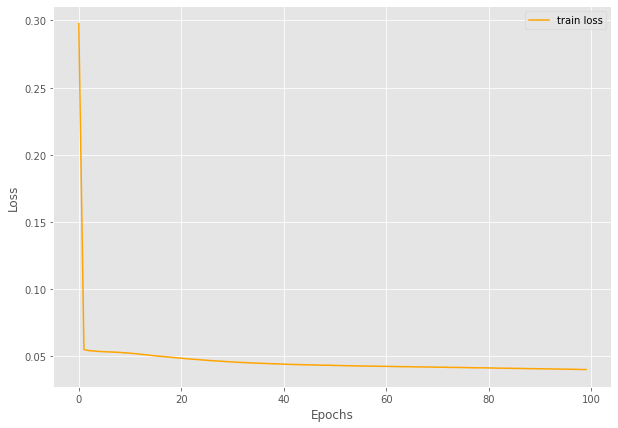

In [41]:
import matplotlib.pyplot as plt
import matplotlib
matplotlib.style.use('ggplot')

# plot and save the train loss graph
plt.figure(figsize=(10, 7))
plt.plot(train_loss, color='orange', label='train loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
# plt.savefig('outputs/multi_head_binary_loss.png')
plt.show()

### Test (ignore when submit kaggle)

In [43]:
# print some info
print(f"[INFO]: Number of testing samples: {X_test.shape[0]}")
print(f"[INFO]: Number of testing features: {X_test.shape[1]}")

# train data loader
test_dataset, test_dataloader = BinaryDataLoader(X_test, y_test, shuffle=False, batch_size=1)

[INFO]: Number of testing samples: 9354
[INFO]: Number of testing features: 486


In [44]:
model = NeuralNetworkYearVenue()
model.load_state_dict(torch.load('status/model_year_venue.pth'))
model.to(device)
model.eval()

NeuralNetworkYearVenue(
  (fc1): Linear(in_features=486, out_features=256, bias=True)
  (out): Linear(in_features=256, out_features=100, bias=True)
)

In [45]:
from preprocessing import *

target_list = transform_labels(y_test, threshold=1)

In [46]:
from sklearn.metrics import accuracy_score, recall_score, f1_score

def get_f1(threshold):
    predict_list = []

    for i, test_sample in enumerate(test_dataloader):
        
        features = test_sample['features']
        
        
        features = torch.reshape(features, (features.shape[0], 1, features.shape[1])).to(device)
        
        outputs = model(features)
        
        outputs = outputs.squeeze()
                
        # get all the labels
        predict_list.append(transform_to_label(outputs, threshold=threshold))

    return predict_list, f1_score(target_list, predict_list, average='weighted')

In [47]:
thresholds = [0.01, 0.02, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6]
f1_scores = []

for i in tqdm(range(len(thresholds))):
    threshold = thresholds[i]

    predict_list, f1 = get_f1(threshold)

    f1_scores.append(f1)

  0%|          | 0/9 [00:00<?, ?it/s]/Users/messifr/Desktop/Messi/MasterY1S2/sml/COMP90051_Project2/code/multi_layer_models/NN_Models.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  features = torch.tensor(features, dtype=torch.float32)
/Users/messifr/Desktop/Messi/MasterY1S2/sml/COMP90051_Project2/code/multi_layer_models/NN_Models.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label_dict[key] = torch.tensor(labels[i], dtype=torch.float32)
 11%|█         | 1/9 [00:28<03:49, 28.72s/it]/Users/messifr/Desktop/Messi/MasterY1S2/sml/COMP90051_Project2/code/multi_layer_models/NN_Models.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().

In [48]:
THRESHOLD = thresholds[f1_scores.index(max(f1_scores))]
THRESHOLD

0.3

In [54]:
# max(f1_scores)
f1_scores

[0.03217569098314048,
 0.033274246786204,
 0.09689634519674081,
 0.1266490732680644,
 0.18306285315357687,
 0.19963939094534452,
 0.1829821136259908,
 0.15826426166468657,
 0.1324441261793674]

# Kaggle Predictions

In [42]:
from preprocessing import for_kaggle

X_kaggle = for_kaggle('year_venue')

# print some info
print(f"[INFO]: Number of testing samples: {X_kaggle.shape[0]}")
print(f"[INFO]: Number of testing features: {X_kaggle.shape[1]}")

# train data loader
kaggle_dataloader = BinaryDataLoader(X_kaggle, None, shuffle=False, batch_size=1)

predict_dict = {}

# for i, test_sample in tqdm(enumerate(kaggle_dataloader), total=len(kaggle_dataloader)):
key = 0
for test_sample in tqdm(X_kaggle):
    # print(f"SAMPLE {i}")
    # extract the features and labels
    features = test_sample
    
    outputs = model(features)
    outputs = outputs.squeeze()
    tmp = {}
    
    for i in range(100):
        tmp[i] = outputs[i].item()
         
    predict_dict[key] = tmp
    
    key += 1

with open('outputs/year_venue.json', 'w') as fp:
    json.dump(predict_dict, fp)

year: 100%|██████████| 800/800 [00:00<00:00, 82832.04it/s]


[INFO]: Number of testing samples: 800
[INFO]: Number of testing features: 486


  0%|          | 0/800 [00:00<?, ?it/s]/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
100%|██████████| 800/800 [00:00<00:00, 1583.52it/s]
